# MCMC Fitting the emission profile to an emission spectrum  

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [1]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [3]:
# TP
alpha_in=0.02
NP=20
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in

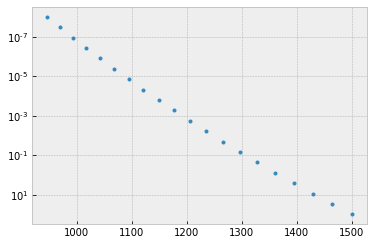

In [4]:
plt.plot(Tarr,Parr,".")
plt.yscale("log")
#plt.xscale("log")
plt.gca().invert_yaxis()

In [5]:
N=500
wav=np.linspace(22930,23955,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

#loading molecular database (HITRAN2012/CO)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
#partition function ratio
qr=mdbCO.Qr(Tarr)

In [6]:
np.min(1.e8/mdbCO.nu_lines),np.max(1.e8/mdbCO.nu_lines)

(22935.23326359264, 24542.515244583345)

In [7]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCO.isoid)))
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [8]:
#Mmol=28.010446441149536
Mmol=3.86 #mean molecular weight
Xco=0.065 #mixing ratio
Tref=296.0
bar2atm=1.0/1.01325
#Pfix=1.e-3*bar2atm#atm

SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,Mmol)

In [9]:
numatrix0=make_numatrix0(nus,mdbCO.nu_lines)
#xsmatrix=jit(vmap(xsvector,(None,0,0,0)))

In [10]:
%timeit -n 3 xsm=xsmatrix(numatrix0,sigmaDM,gammaLM,SijM).block_until_ready()

736 ms ± 184 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [11]:
%timeit -n 3 xsm=cxsmatrix(numatrix0,sigmaDM,gammaLM,SijM).block_until_ready()

728 ms ± 164 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [12]:
xsm=xsmatrix(numatrix0,sigmaDM,gammaLM,SijM)

In [13]:
xsm=cxsmatrix(numatrix0,sigmaDM,gammaLM,SijM)

In [14]:
from scipy.constants import  m_u

In [15]:
#1 bar = 10^5 Pa = 10^6 dyn/cm2, dyn=g cm/s2
g=2500.0 # cm/s2
#molecular weight = Mmol*m_u*1.e3 (g)
tfac=1.e6*Xco/(Mmol*m_u*g*1.e3)

numic=1.e4/np.mean(nus)
gi = planck.nB(Tarr,numic)

DeviceArray([], dtype=float32)

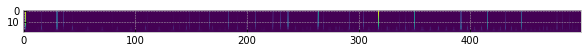

In [16]:
fig=plt.figure(figsize=(10,10))
plt.imshow(xsm)
xsm[xsm==0.0]

In [33]:
@jit
def rtFe(nu0):
    xsm=cxsmatrix(numatrix0-nu0,sigmaDM,gammaLM,SijM)
    dtauM=dParr[:,None]*xsm*tfac
    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(len(nus))
    Qv=(1-TransM)*gi[:,None]
    
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(len(nus))
    TransM=jnp.vstack([onev,TransM])
    Fx=1.e10*(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    return Fx

In [17]:
@jit
def rtF(nu0):
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228
    xsm=cxsmatrix(numatrix0-nu0,sigmaDM,gammaLM,SijM)
    dtauM=dParr[:,None]*xsm*tfac
    dtauM2=dtauM**2
    dtauM3=dtauM**3
    dtauM4=dtauM**4
    dtauM5=dtauM**5
    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1B=jnp.exp(-dtauM)/dtauM*\
    (dtauM4+B1*dtauM3+B2*dtauM2+B3*dtauM+B4)/\
    (dtauM4+C1*dtauM3+C2*dtauM2+C3*dtauM+C4)
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)

    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(len(nus))
    Qv=(1-TransM)*gi[:,None]
    
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(len(nus))
    TransM=jnp.vstack([onev,TransM])
    Fx=1.e10*(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    return Fx

In [34]:
%timeit rtFe(0.0).block_until_ready()

691 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
Fx0=rtF(0.0)
Fx1=rtF(0.3)

In [35]:
Fx0=rtFe(0.0)
Fx1=rtFe(0.3)

In [20]:
def check(a):
    return a[a!=a],jnp.min(a),jnp.max(a)

In [21]:
check(dParr)

(DeviceArray([], dtype=float32),
 DeviceArray(7.0236488e-09, dtype=float32),
 DeviceArray(70.23649, dtype=float32))

In [23]:
check(Fx0)

(DeviceArray([], dtype=float32),
 DeviceArray(0.00462048, dtype=float32),
 DeviceArray(1.7477844, dtype=float32))

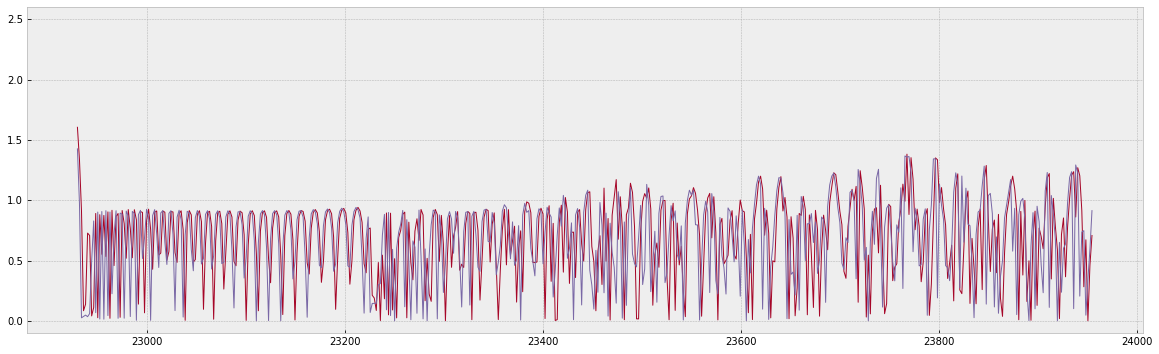

In [36]:
fig=plt.figure(figsize=(20,6.0))

plt.plot(wav[::-1],Fx0,lw=1,color="C1")
plt.plot(wav[::-1],Fx1,lw=1,color="C2")
#plt.yscale("log")
#plt.xlim(22950,23300)
plt.ylim(-0.1,2.6)
plt.savefig("highredCO.png")

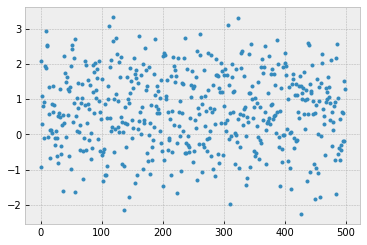

In [39]:
sigin=1.0
N=len(Fx0)
data=Fx0+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [40]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [28]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [29]:
device_logsij=jnp.array(mdbCO.logsij0)


In [30]:
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228

In [71]:
  
def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    #sD = numpyro.sample('sD', dist.Exponential(1.))
    #gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-1.0,1.0))
    
    #dalpha = numpyro.sample('dalpha', dist.Uniform(1.9,2.1)) #
    #alpha=dalpha*0.01
    
    
    alpha=0.02
    #model
    #numatrix0=make_numatrix0(nu,nu_lines)
    Tarr = 1500.*(Parr/Parr[-1])**alpha    
    #line computation
    SijM=vSij(Tarr,device_logsij,mdbCO.nu_lines,mdbCO.elower,qt)
    gammaLM = vgamma_hitran(Parr,Tarr,Parr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
    #+ gamma_natural(A) #uncomment if you inclide a natural width
    sigmaDM=vdoppler_sigma(mdbCO.nu_lines,Tarr,Mmol)
    
    gi = planck.nB(Tarr,numic)
    xsm=xsmatrix(numatrix0-nu0*0.01,sigmaDM,gammaLM,SijM)    
    dtauM=dParr[:,None]*(xsm)*tfac
    
    #dtauM2=dtauM**2
    #dtauM3=dtauM**3
    #dtauM4=dtauM**4
    #dtauM5=dtauM**5
    #ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    #ep1B=jnp.exp(-dtauM)/dtauM*\
    #(dtauM4+B1*dtauM3+B2*dtauM2+B3*dtauM+B4)/\
    #(dtauM4+C1*dtauM3+C2*dtauM2+C3*dtauM+C4)
    #ep=jnp.where(dtauM<=1.0, ep1A, ep1B)
    #TransM=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    #TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    
    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(len(nus))
    Qv=(1-TransM)*gi[:,None]
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(len(nus))
    TransM=jnp.vstack([onev,TransM])
    mu=1.e10*A*(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))

    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

kernel = NUTS(model)
#kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

warmup:   6%|▌         | 17/300 [05:21<4:22:09, 55.58s/it, 159 steps of size 1.54e-02. acc. prob=0.68]

In [ ]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

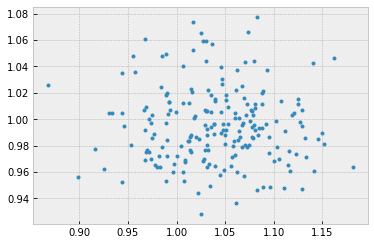

In [60]:
plt.plot(posterior_sample["A"],posterior_sample["sigma"],".")

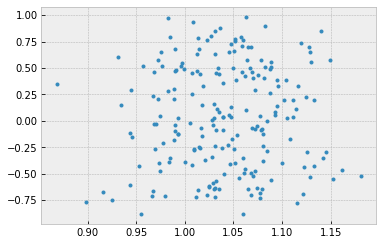

In [61]:
plt.plot(posterior_sample["A"],posterior_sample["nu0"],".")

In [62]:
predictions["y"]

DeviceArray([[-0.9435167 ,  0.40321955, -0.4523026 , ...,  0.10535221,
              -0.77321416,  0.27595165],
             [-0.11170448,  1.8011138 ,  0.26287416, ...,  2.1626344 ,
               1.7580822 ,  1.7103052 ],
             [ 0.2643121 , -0.40417022,  1.1280457 , ...,  2.5233212 ,
               1.8675255 ,  2.7803633 ],
             ...,
             [ 3.6757839 ,  1.1612612 , -1.4715409 , ..., -0.37761572,
               2.036219  ,  2.843218  ],
             [ 0.4101067 ,  2.4835088 , -0.78929466, ...,  0.22849196,
               1.8476756 ,  3.2118592 ],
             [ 0.0628255 ,  0.9979615 , -1.4775468 , ...,  1.6075214 ,
               2.3536499 ,  3.817329  ]], dtype=float32)

In [63]:
hpdi_mu = hpdi(predictions["y"], 0.9)

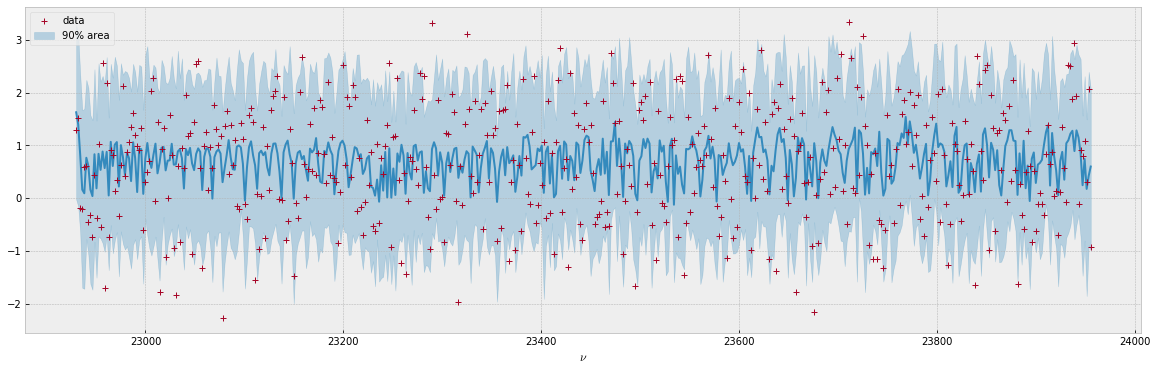

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

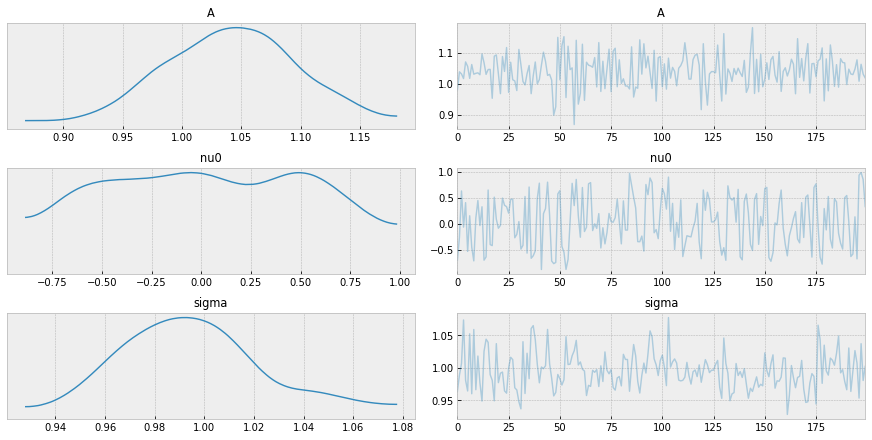

In [69]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","nu0","sigma"])
plt.show()

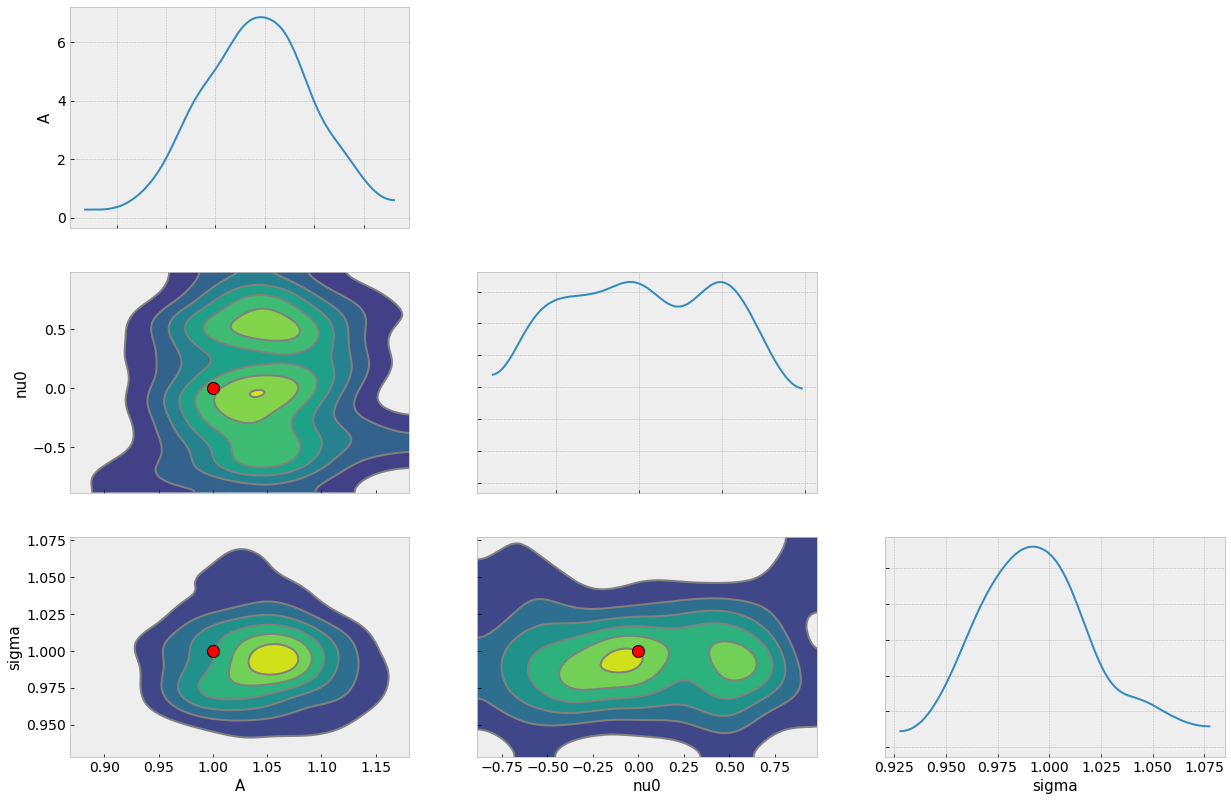

In [70]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [45]:
sigin

1.0

## LA RT (class)

In [17]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.dParr=dParr
jaxrt.NP=NP
jaxrt.k=k

In [21]:
#run using flatten() and reshape()
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.run(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [20]:
#runx (using vmap)
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.runx(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [24]:
np.shape(numatrix)

(1000, 1000)

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:49<00:00, 17.74it/s, 7 steps of size 5.12e-01. acc. prob=0.91]    



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10   2608.95      1.00
        gL      1.06      1.04      0.75      0.01      2.38   2098.59      1.00
       nu0      0.75      0.07      0.75      0.65      0.88   2031.69      1.00
        sD      0.99      1.00      0.70      0.00      2.24   2271.31      1.00
     sigma     10.04      0.23     10.03      9.66     10.40   2238.15      1.00

Number of divergences: 0


## Note (Jan 16 2021): 
currently runx (using vmap) is ~ 2 times slower than run (using flatten() and reshape)

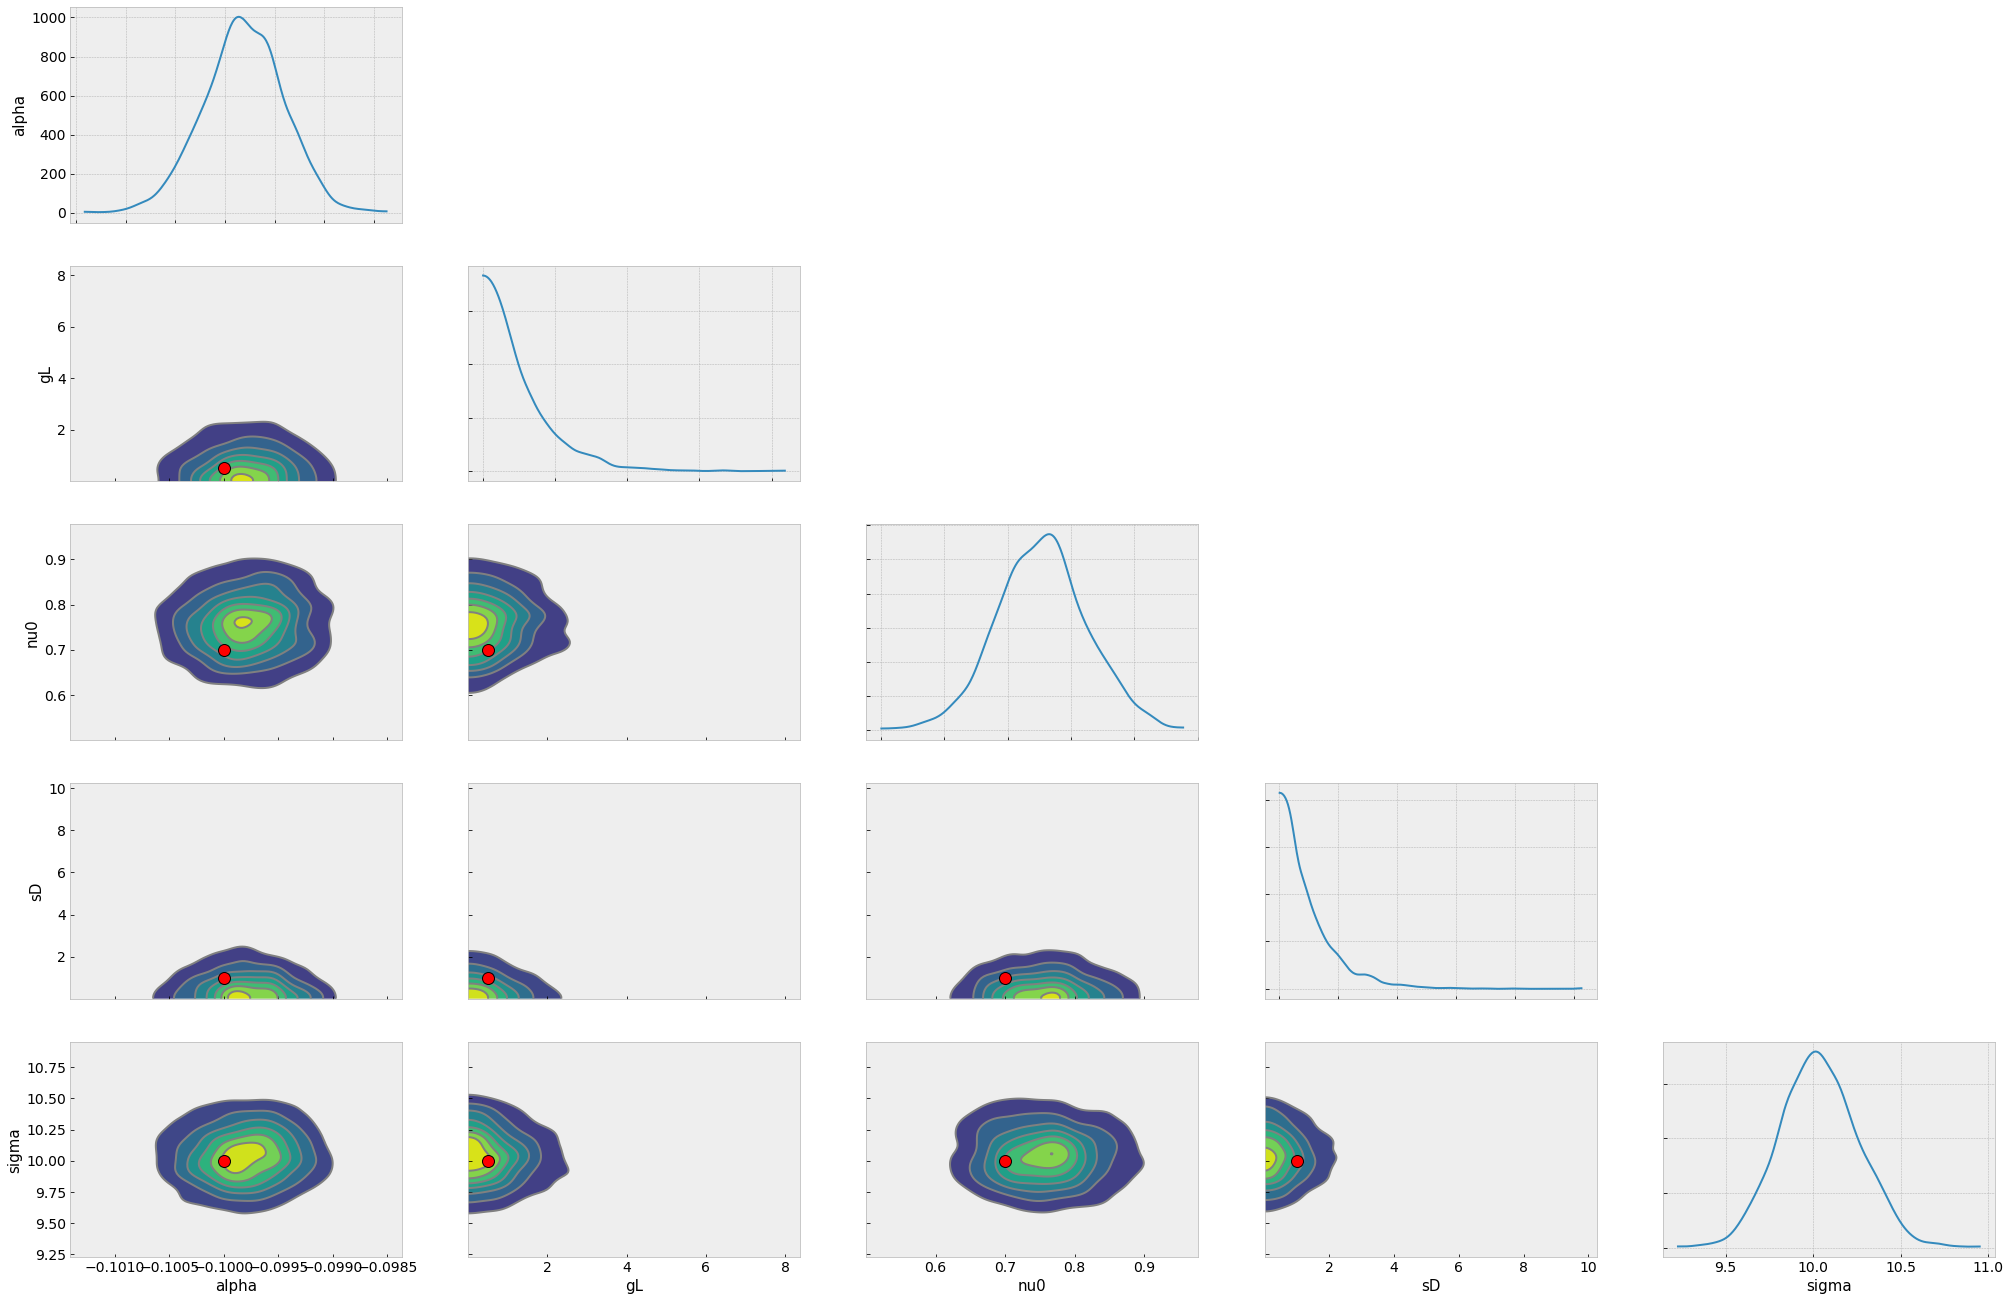

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=10.0
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

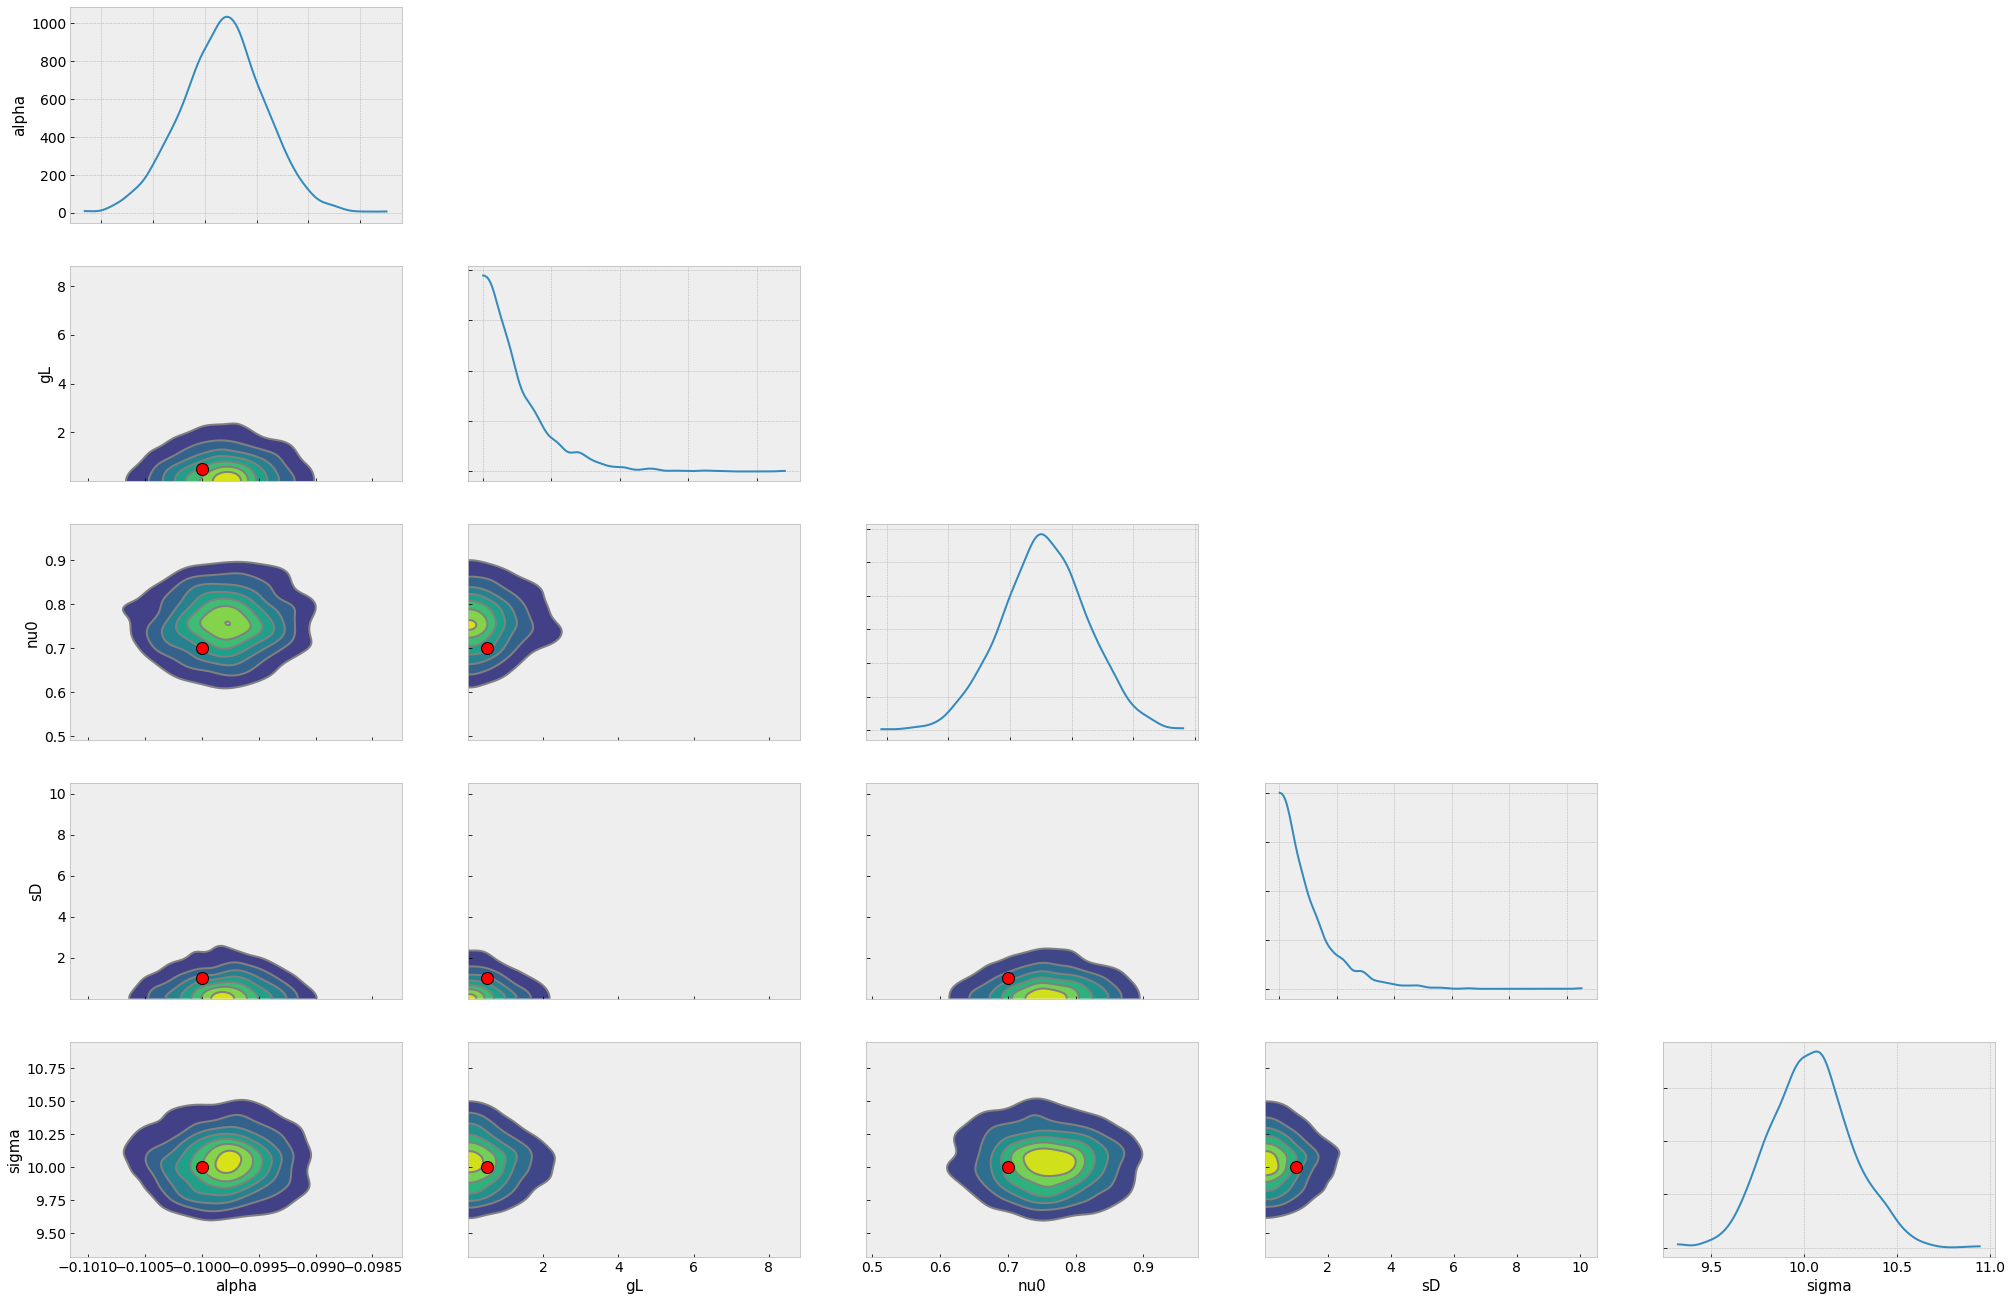

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [36]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

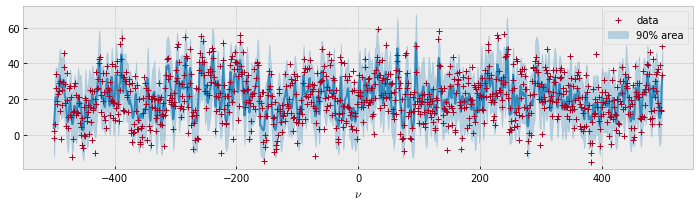

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()

## Layer scan

In [9]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.NP=NP
jaxrt.k=k

In [10]:
numic=0.5
F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
init=[F0,Parr[0],0.7,1.0,0.5]
jaxrt.Tarr=Tarr
%timeit jaxrt.layerscan(init)

2.93 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


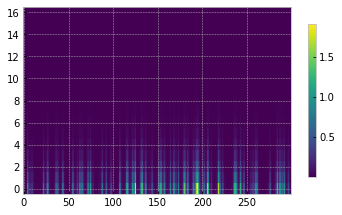

In [11]:
F0=jnp.zeros(len(nuarr))
init=[F0,Parr[0],0.7,1.0,0.5]
FP,tauarr=scan(jaxrt.add_layer,init,Tarr.T,NP)

fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(tauarr)
plt.colorbar(c,shrink=0.7)
ax.set_aspect(0.7/ax.get_data_ratio())
plt.gca().invert_yaxis()

In [12]:
from jax import grad
F0=jnp.zeros(len(nuarr))
#F0=0.0
init=[F0,Parr[0],0.7,1.0,0.5]
#scan(add_layer,init,Tarr,NP)

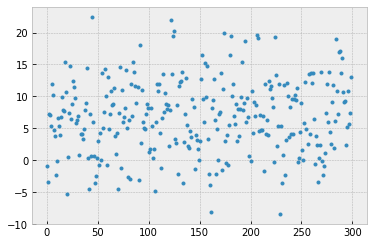

In [16]:
@jit
def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(jaxrt.add_layer,init,Tarr,NP)
    return FP[0]*3.e4

sigin=5.0
data=g(Tarr)+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [17]:
#jaxrt.Tarr=Tarr

#probabilistic model using numpyro
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    numic=0.5
    nuarr=nu
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    init=[F0,Parr[0],nu0,sD,gL]
    jaxrt.Tarr=Tarr
    mu=jaxrt.layerscan(init)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [13:50<00:00,  2.94it/s, 15 steps of size 3.07e-01. acc. prob=0.90]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        gL      0.76      0.37      0.75      0.18      1.38    665.32      1.00
       nu0      0.47      0.21      0.48      0.13      0.81   1239.00      1.00
        sD      1.04      0.43      1.05      0.24      1.65    645.96      1.00
     sigma      4.88      0.20      4.87      4.55      5.19   1361.18      1.00

Number of divergences: 57


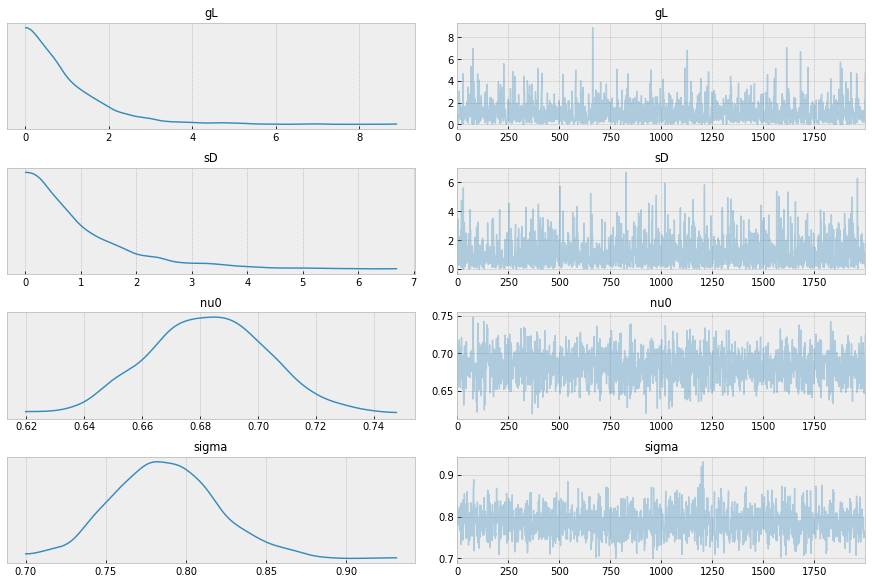

In [22]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma"])
plt.show()

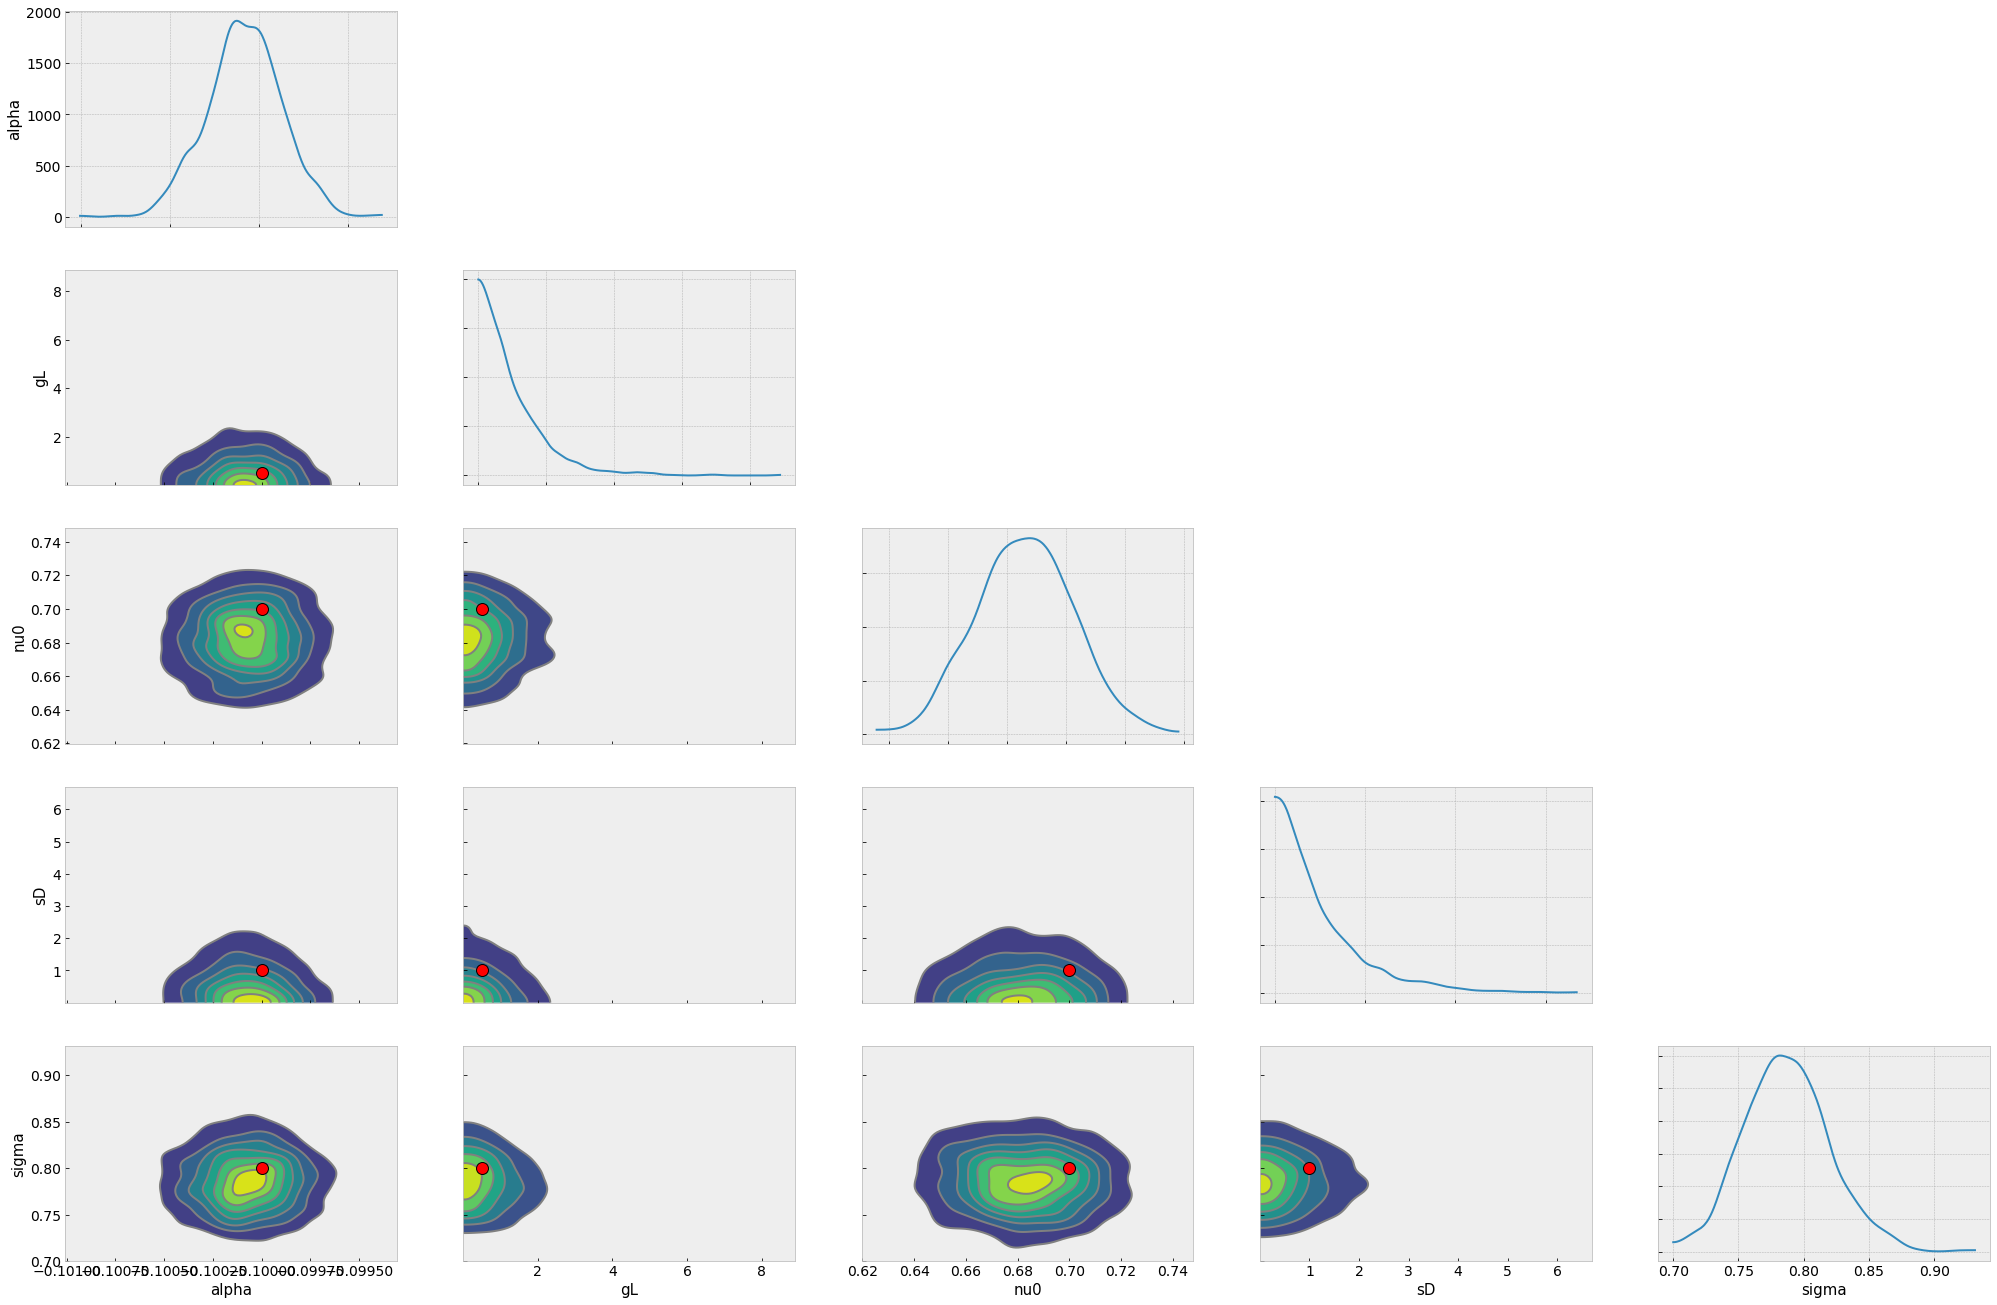

In [24]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [25]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

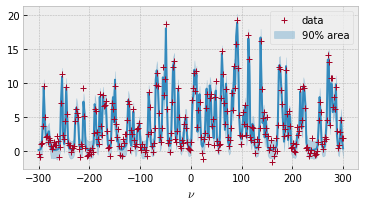

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()